# <p style="text-align:center;"> Movie Recommendation Challenge <p>
The internet has changed how we consume content. We have moved from using compact disks to access content such as movies and series to having access to a catalog with thousands of movies/series through streaming services such as Netflix and Showmax. This is where the paradox of choice kicks in, because we have so many options to choose from it has become increasingly difficult to decide what to watch. To address this issue, companies need to taylor their services to the consumption habits of customers and one way of doing this is through recommendation engines. This project aims to construct a robust movie recommendation algorithm that can predict how a user will rate a movie based on their consumption traits and preferences.

<div style="width:100%;text-align: center;"> <img align=middle src="https://raw.githubusercontent.com/nkonyanihlulani/pictures/main/329633.jpg" style="height:500px;margin-top:3rem;"> </div>

## Table of Contents
* [Environment Setup](#section-one)
* [Installing Packages](#section-two)
* [Reading in Data and Overview](#section-three)
* [Exploratory Data Analysis](#section-four)
* [Data Preprocessing](#section-five)

<a id="section-one"></a>
## Environment Setup

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


<a id="section-two"></a>
## Installing Packages

In [2]:
# Install packages here

# Packages for data processing
import numpy as np
import pandas as pd

import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
sns.set_theme()

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

<a id="section-three"></a>
## Reading in Data and Overview

In [3]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

#### A bird's eye view of each of the datasets provided

#### df_train

In [4]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


The train dataframe has 4 columns:
* userId - Id assigned to each user in our dataset
* movieId - Id assigned to each movie title
* rating - rating assigned to a specific movie by a specific user.
 * ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars)
* timestamp - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

The number of obsertions

In [5]:
print('df_train has '+str(len(df_train))+' observations')

df_train has 10000038 observations


Now Let us check if our dataframe contains any missing values

In [6]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

#### movies_df

In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


This movies dataframe has 3 columns namely:
* movieId
* title of the movie
* genres

We are going to link the 2 dataframes using movieId column in the data preprocessing stage

#### df_imdb

In [8]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The imdb dataframe has 5 columns:
* movieId
* title_cast 
* Directors names
* runtime
* budget
* plot_keywords
Again, this dataframe will be linked to df_train through the movieId column

Tag genome encodes how strongly movies exhibit particular properties represented by tags. We looked at both the df_genome_tags and df_genome_scores, starting with the former

In [9]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


This dataframe has two columns:
* tagId
* tag -description of the tags

In [10]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


This dataframe has 3 columns:
* movieId
* tagId
* relevance - computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews

This dataframe will be linked with df_train through the movied

Now let us look at the tags to each movie by the users

In [11]:
df_tags.tail()

,userId,movieId,tag,timestamp
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181
1093359,162534,189169,robbery,1527518193


In [12]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


<a id="section-four"></a>
## Exploratory Data Analysis
Discovery phase and data understanding

#### Distribution of Ratings

Descriptive Statistics

In [13]:
df_train['rating'].describe()

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [14]:
#creating a dataframe with ratings and their counts

rating_counts = df_train.groupby(['rating']).count().reset_index().rename(columns={'userId':'count'})[['rating','count']]

rating_counts.head()

,rating,count
0,0.5,157571
1,1.0,311213
2,1.5,159731
3,2.0,656821
4,2.5,505578


We use the dataframe above to obtain a bargraph showing the distribution of bars

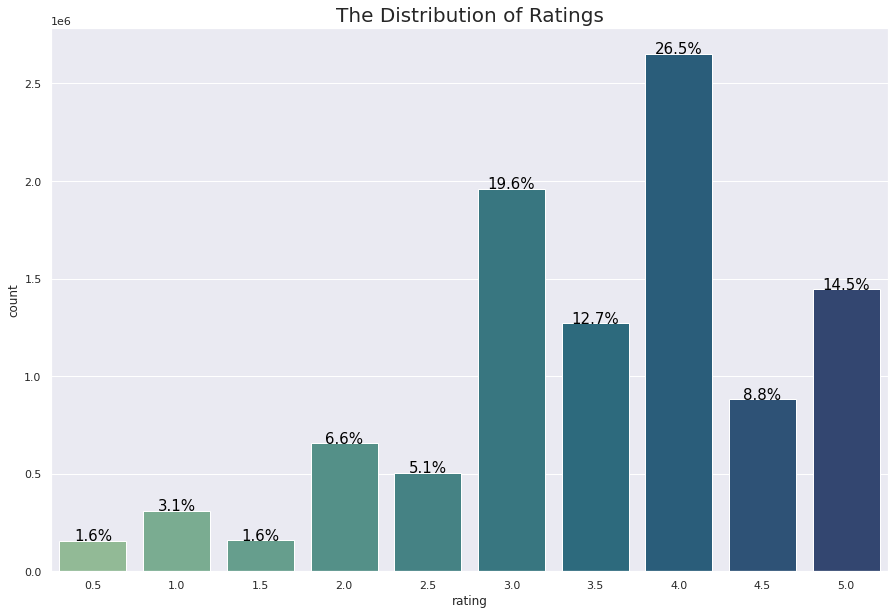

In [15]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x='rating',y='count',data=rating_counts,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')
    
plt.show()

##### Results
* The most common rating given by users (26.5%) is 4. 
* The ratings appear to be skewed to the left (evidenced by the long tail to the left). This means that there are a few movies who received lower ratings compared to those that received higher ratings


The we calculated the coefficient of skewness to check our above findings.

In [16]:
#calcuting skew
print('The Coefficient of Skewness is : '+str(rating_counts['count'].skew()))

The Coefficient of Skewness is : 0.9316640025763425


Surprising Result! Maybe because of the distribution appears to be loosely bimodal?

#### Number of Unique Users

In [17]:
print('Train df has '+str(df_train['userId'].nunique())+' unique users')

Train df has 162541 unique users


#### Number of ratings per User?

#### Most common Genres

In [18]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


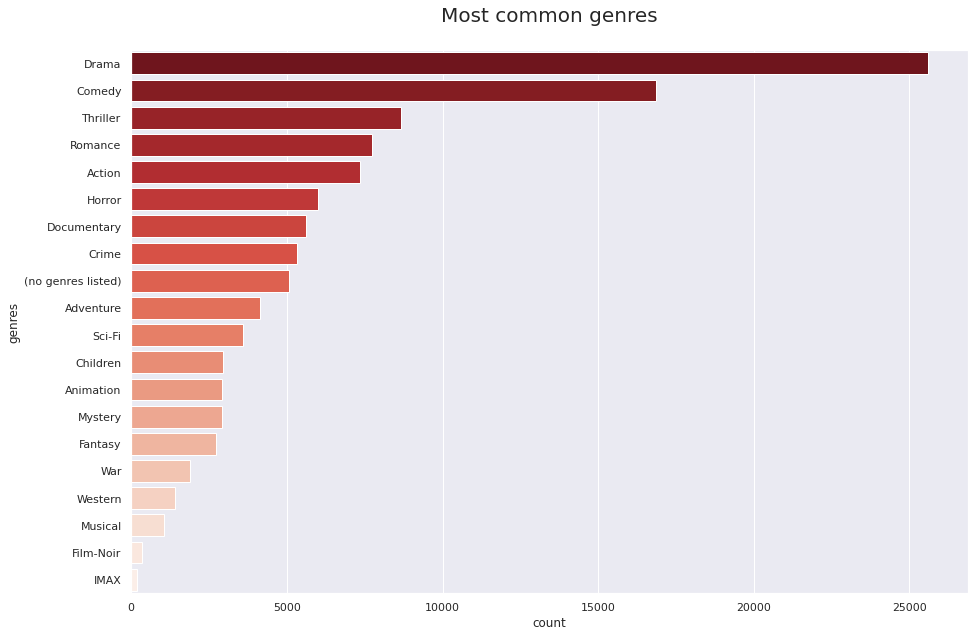

In [19]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Results**

#### Average Rating Per Genre

In [20]:
#joining train_df and movie_genres
rating_genre = pd.merge(df_train,movies_genres, on='movieId',how='left')

#dataframe of average rating according to genr
ave_per_genre = rating_genre.groupby(['genres'])['rating'].mean().reset_index()

#sorting values from largest to smallest
ave_per_genre = ave_per_genre.sort_values(by='rating',ascending=False).reset_index()

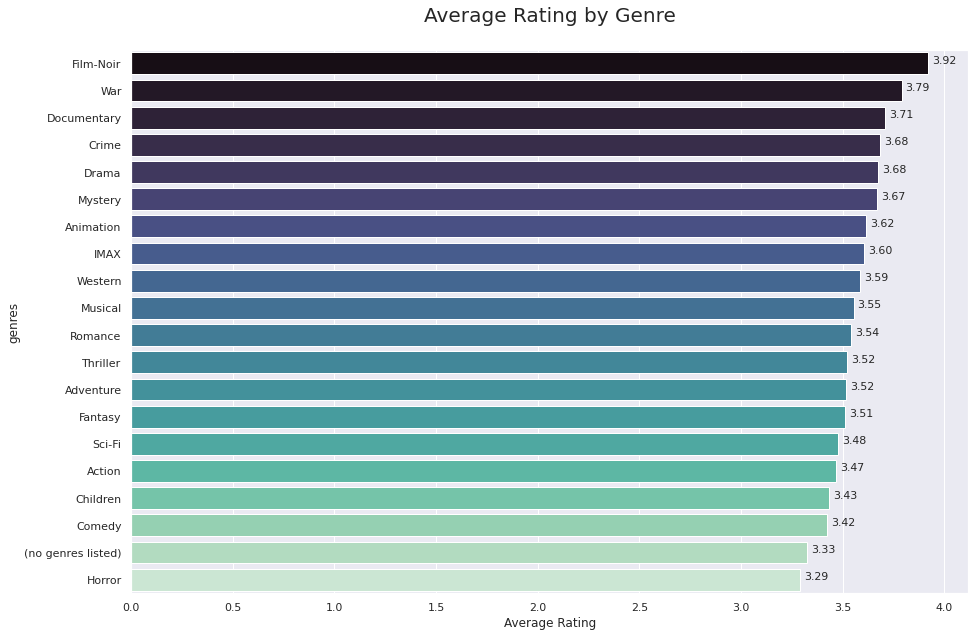

In [21]:
#horizontal barchart plotting based on the above
plot = plt.figure(figsize=(15, 10))
plt.title('Average Rating by Genre\n', fontsize=20)
a = sns.barplot(x='rating',y="genres", data=ave_per_genre,
              palette='mako')

#creating horizontal label
a.set_xlabel('Average Rating')

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

**Results**
* The average ratings according to genre were in a narrow range 
* Film-Noirs, War Movies , and Documentaries recieved the highest average ratings.
* Film-Noirs received the highest rating even though they are the second lowest reviewed movies.
* Comedies and Horrors received the lowest ratings. Possible explanation: too predictable?
* Comedies recieved the second lowest average rating even though they were in the top 2 reviewed movies.

#### Do Budget and/or Runtime Affect Ratings

In [22]:
#Merging the dataframe to obtain the budget
df_budget = pd.merge(df_train,df_imdb[['movieId','budget']], on ='movieId', how='left')

#string the dollors
pattern = r'\$'
df_budget['budget'] = df_budget['budget'].apply(lambda x: re.sub(pattern, '', str(x)))

#stripping the commas
pattern = r'\,'
df_budget['budget'] = df_budget['budget'].apply(lambda x: re.sub(pattern, '', str(x)))

#convert to numerical value
df_budget['budget'] = pd.to_numeric(df_budget['budget'], errors='coerce')

#budget according to rating
budget_rating = df_budget.groupby(['rating'])['budget'].mean().reset_index()

In [23]:
#merging dataframe to obtain budget
df_runtime = pd.merge(df_train,df_imdb[['movieId','runtime']], on ='movieId', how='left')

#budget according to rating 
runtime_rating = df_runtime.groupby(['rating'])['runtime'].mean().reset_index()

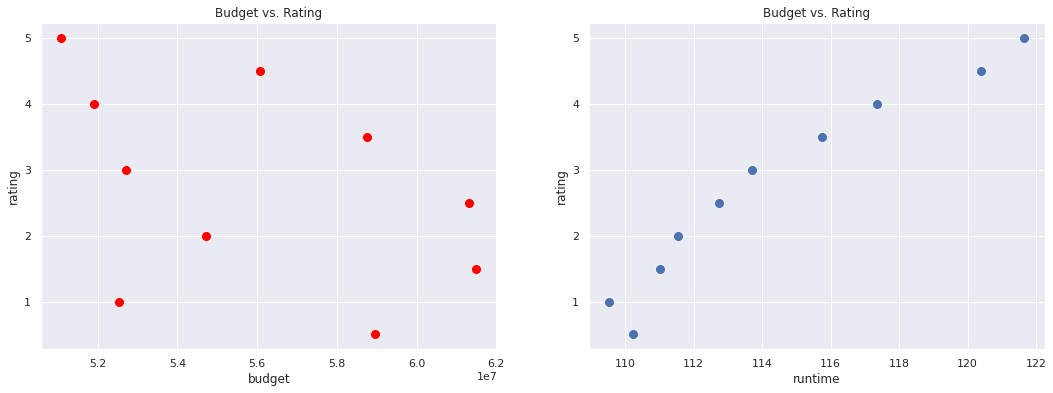

In [24]:
#scatter plot of rating and  Budget
fig, axes = plt.subplots(1,2, figsize=(18, 6), squeeze=False)

plot1 = sns.scatterplot(x='budget', y='rating', data =budget_rating, s=100, color='red', ax=axes[0,0])
plot2 = sns.scatterplot(x='runtime',y='rating', data=runtime_rating, s=100, ax =axes[0,1])
plot1.set_title('Budget vs. Rating')
plot2.set_title('Budget vs. Rating')

plt.show()

**result**
* It seems that ther is no obvious relationship between the budget of the movie and the rating
* With the exception of one point, as runtime increases the rating also increase in a linear fashion

##### Top 50 Occurring Cast Members

In [25]:
#creating empty pandas dataframe
df_imdb_mod =pd.DataFrame({})

# joining the names and surnames
pattern = r'\s+'
df_imdb_mod['title_cast'] = df_imdb['title_cast'].apply(lambda x: re.sub(pattern, '', str(x)))

#tokenizing the names and creating new column (for later)
df_imdb_mod['title_cast_sep'] = df_imdb_mod['title_cast'].str.split('|')

# joining the names back to strings
sep=" "
df_imdb_mod['title_cast'] = df_imdb_mod['title_cast_sep'].apply(lambda x : sep.join(x))

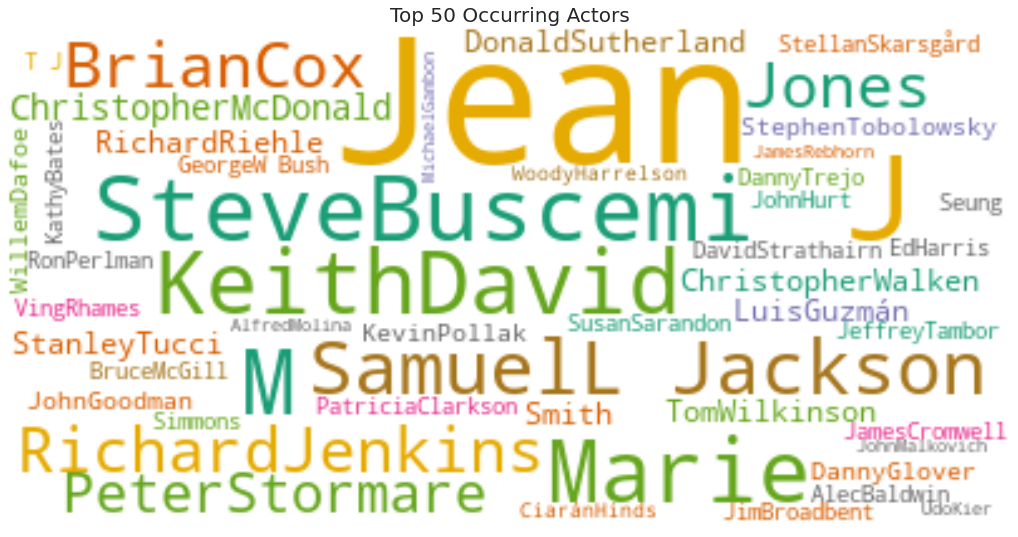

In [26]:
all_cast ="".join([cast for cast in df_imdb_mod['title_cast']])
fig = plt.figure(figsize=(18,10))

wc = WordCloud(background_color="white",
               colormap="Dark2", max_font_size=70,
               random_state=42,max_words=50)

wc.generate(all_cast)
plt.title('Top 50 Occurring Actors', fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Results**

#### Now Let us Look at The Lead Actors
We are assuming that the lead actor/actress is the first name mentioned on title credits



In [27]:
cast_rating = pd.merge(df_train,df_imdb[['movieId','title_cast']],on='movieId', how='left')
cast_rating['title_cast'] = cast_rating['title_cast'].apply(lambda x: str(x))
cast_rating['title_cast'] = cast_rating['title_cast'].str.split('|')

cast_rating['lead_actor'] = cast_rating['title_cast'].apply(lambda x: x[0])

lead_rating = pd.DataFrame({})
lead_rating = cast_rating.groupby('lead_actor')['rating'].mean().reset_index()


#### Top 10 Lead Actors

In [28]:
lead_rating.sort_values(by='rating',ascending =False).head(10)

,lead_actor,rating
5705,Norma Jean Almodovar,5.0
1994,Dov Houle,5.0
2884,Hristo Shopov,5.0
4167,Kevin Sheppard,5.0
3124,James Burke,5.0
7416,Tom Pelphrey,5.0
4217,Kirby Heyborne,5.0
804,Benjalil Amanallah,5.0
4259,Kristen Miller,5.0
60,Adam Rothenberg,5.0


#### Bottom 10  Lead Actors

In [29]:
lead_rating.sort_values(by='rating',ascending =False).tail(10)

,lead_actor,rating
7691,Wahid Chan,0.5
5850,Patrick Duffy,0.5
6918,Sido,0.5
3937,Justine Waddell,0.5
2598,Gilbert M. 'Broncho Billy' Anderson,0.5
1523,Cordell McQueen,0.5
6455,Roman Klosowski,0.5
611,Arielle Dombasle,0.5
3095,Jake Hoffman,0.5
7912,Zoë Poledouris,0.5


#### Most Frequently Occurring Directors

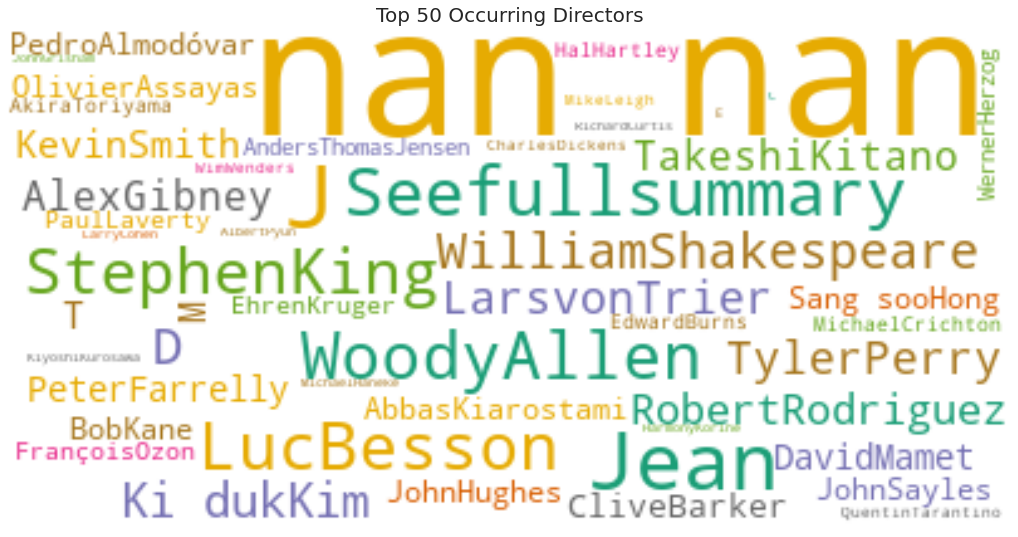

In [30]:
#joining names and surnames
pattern = r'\s+'
df_imdb_mod['director'] = df_imdb['director'].apply(lambda x: re.sub(pattern, '', str(x)))

directors = ' '.join([str(d) for d in df_imdb_mod['director']])

fig = plt.figure(figsize=(18,10))

wc = WordCloud(background_color="white",
               colormap="Dark2", max_font_size=70,
               random_state=42,max_words=50)

wc.generate(directors)
plt.title('Top 50 Occurring Directors', fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Now Let Us Look at The Top 10 Rated Directors

In [31]:
#joining df_train and df_imdb using the movieId column
director_rating = pd.merge(df_train,df_imdb[['movieId','director']], on='movieId', how='left')
director_rating = director_rating.groupby('director')['rating'].mean().reset_index()

#Obtaing Top 10
director_rating.sort_values(by='rating',ascending =False).head(10)

,director,rating
8013,Robert W. Allan,5.0
9208,Till Schauder,5.0
7259,Paul Osborne,5.0
9519,Valarie Trapp,5.0
9020,T Bone Burnett,5.0
7729,Ric Klass,5.0
8064,Roger Avon,5.0
7689,Rebecca Cammisa,5.0
6736,Mushon Salmona,5.0
4896,Joshua Sinclair,5.0


#### Bottom 10 Rated Directors

In [32]:
director_rating.sort_values(by='rating',ascending =False).tail(10)

,director,rating
9650,Wai-Lun Lam,0.5
6612,Mike Elliott,0.5
3237,Giuliano Montaldo,0.5
4568,John Friedmann,0.5
6496,Michael Preece,0.5
8618,Siegfried,0.5
3850,James Bird,0.5
8687,Spike Brandt,0.5
451,Andrea Grano,0.5
0,50 Cent,0.5


#### Most Common Tags

In [33]:
tags = df_tags.groupby(['tag'])['movieId'].count().reset_index().rename(columns={'movieId':'count'})
tags.sort_values(by='count',ascending=False).head(10)

,tag,count
62208,sci-fi,8330
30252,atmospheric,6516
28231,action,5907
36136,comedy,5702
66827,surreal,5326
31464,based on a book,5079
69573,twist ending,4820
43578,funny,4738
70986,visually appealing,4526
39957,dystopia,4257


#### Least Common Tags

In [34]:
tags.sort_values(by='count',ascending=False).tail(10)

,tag,count
30493,author:Ed McBain,1
30497,author:Elizabeth Gaskell,1
30499,author:Emmanuelle Argan,1
30500,author:Erich KÃ¤stner,1
30502,author:Eugene Burdick,1
30503,author:Evan S. Connell,1
30505,author:Fannie Hurst,1
30506,author:Felix Salten,1
30507,author:Fennimore Cooper,1
73049,카운트다운,1


<a id="section-five"></a>
## Data Preprocessing 

In [35]:
## Here you will sort your data out and process it accordingly

#
min_movie_ratings = 500
filter_movies = df_train['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 500
filter_users = df_train['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df_train[(df_train['movieId'].isin(filter_movies)) & (df_train['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df_train.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))



reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_train[['userId','movieId','rating']], reader)

The original data frame shape:	(10000038, 4)
The new data frame shape:	(750263, 4)


## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



### Collaborative Filtering Models

* SVD
* SVDpp
* SlopeOne
* KNNBasic
* KNNWithMeans
* CoClustering

In [36]:
# Apply your modelling her
# algo = SlopeOne()
# cross_validate(algo, data, measures=['RMSE'],cv=3,verbose=False)
# benchmark = []
# # Iterate over all algorithms
# for algorithmn [SVD(), SVDpp(), SlopeOne(), NMF(), KNNBasic(), KNNWithMeans(), CoClustering()]:
#     # Perform cross validation
#     results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
#     # Get results & append algorithm name
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)
    
# pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

In [37]:
#algo.predict(uid=5163,iid=57667)

### Content Based Models



# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [38]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [39]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [40]:
df.to_csv('my_test_output.csv', index = False)